In [56]:
import numpy as np
import time
import math as m
import matplotlib
import matplotlib.pyplot as plt 
import random
from typing import List

In [4]:
#exemple
Graph = np.array([                           
     [ False, True, False, False, False, False, False, False],
     [ True, False, True, False, False, False, False, True],
     [ False, True, False, True, False, False, False, False],
     [ False, False, True, False, True, False, False, False],
     [ False, False, False, True, False, True, True, False],
     [ False, False, False, False, True, False, False, False],
     [ False, False, False, False, Truegit, False, False, True],
     [ False, True, False, False, False, False, True, False],
])

In [158]:
class Coloring:
    def __init__(self , graphe:np.ndarray)->None:
        self.graphe = graphe
    
    #Return adjacent nodes
    def adjacent(self,node :int)->np.ndarray: 
        return np.where(self.graphe[node][:] == True)[0]
    
    #A dictionnary to count the colors in a solution (Can be updated during the algorithm avoiding the recalculation of the number of colors in a solution)
    def count_colors(self , Soluce:np.ndarray):
        count = {}
        for color in Soluce:
            if color in count.keys():
                count[color]+=1
            else :
                count[color] = 1
        return count 
    
    #Return the possible colors to a node giving a Solution and a graphe
    def possible_colors(self,soluce:np.ndarray,node:int,count:dict)->np.ndarray :
        adj = self.adjacent(node)
        #Non possible colors
        AdjColors = np.unique( np.array( [soluce[V] for V in adj] ) )
        colors = np.fromiter(count.keys(), dtype=int)
        possibleColors = np.setdiff1d(colors,AdjColors)
        new_color = max(colors)+1
        possibleColors = np.append(possibleColors,new_color)
        return possibleColors
    
    def affect_color(self,Soluce, count_color ,node, new_col):
        old_col = Soluce[node]
        Soluce[node] = new_col
        count_color[old_col] = count_color[old_col]-1
        if count_color[old_col] == 0:
            count_color.pop(old_col)
        if new_col in count_color.keys():
            count_color[new_col] = count_color[new_col] + 1
        else : 
            count_color[new_col] = 1
        return Soluce , count_color
    
    #read instance from .col files
    def from_file(self,file_path:str):
        with open(file_path) as f:
            line = f.readline()
            while line[0] != "p":
                line = f.readline()
            n = int(line.split()[2])
            adj_mat = []
            for i in range(0,n):
                adj_mat.append([False]*n)
            for line in f:
                if line[0] == "e":
                    w, v = map(int, line.split()[1:])
                    adj_mat[w-1][v-1] = adj_mat[v-1][w-1] = True
        self.graphe = adj_mat
        return np.array(adj_mat)
        
    def solve():
        pass


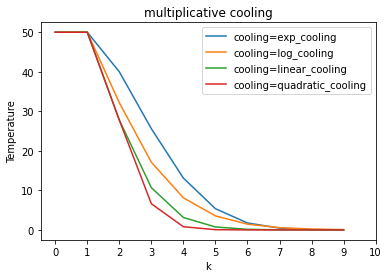

In [159]:
#multiplicative cooling
def exp_cooling(Temp:float, alpha : float , k:int )->float:
    return T*(alpha**k)

def log_cooling(Temp:float, alpha : float , k:int )->float:
    return T / (1 + alpha *m.log(1+k))

def linear_cooling(Temp:float, alpha : float , k:int )->float:
    return T / (1 + alpha*k)

def quadratic_cooling(Temp:float, alpha : float , k:int )->float:
    return T / (1 + alpha*(k**2))


Temp = 50
a = 0.8
f1 = exp_cooling
f2 = log_cooling
f3 = linear_cooling
f4 = quadratic_cooling
functions = [f1,f2,f3,f4]
fig, ax = plt.subplots()  
max_iter = 10
x = np.arange(max_iter)
for f in functions:
    total_temperature = np.zeros(max_iter)
    T = Temp
    for i in range(max_iter):
        total_temperature[i] =  total_temperature[i] + T 
        T = f(T, a , i)
    ax.plot(x, total_temperature, label=f"cooling={f.__name__}")
ax.set_xticks(np.arange(0, max_iter+1, max_iter/10))
ax.set_title("multiplicative cooling")
ax.set_xlabel("k")
ax.set_ylabel("Temperature")
ax.legend() 
plt.show()

In [211]:
class Simulated_annealing(Coloring):
    
    def __init__ (self,graphe:np.ndarray,init_soluce:np.ndarray, alpha : float,nb_level :int,temperature:float,max_iter:int = 100,
                  max_stagnation : int = 10,nb_noeuds:int = 3,cooling_funct = exp_cooling)->None:
        super().__init__(graphe)
        self.graphe=graphe
        self.coloration = init_soluce
        self.alpha = alpha
        self.maxIter = max_iter
        self.temperature = temperature
        self.cooling = cooling_funct
        self.stagnation = max_stagnation
        self.nb_level = nb_level
        self.nb_noeuds = nb_noeuds
        self.soluce_records = np.array([])
        self.time_processing = None
        
    def from_file(self,file_name:str)-> np.ndarray:
        self.graphe = super().from_file(file_name)
        return self.graphe
    
    def save(self,file_path):
        f = open(file_path, "w")
        f.write( "# Solution for the instance "+file_path+"\n" )
        f.write( "Minimum number of colors used : %d \n"%self.soluce )
        f.write( "Execution time :: %f \n"%self.time_processing )
        f.write( "Color Affectation to the nodes : \n")
        [f.write( "Node "+ str(i)+ " :: "+str(self.coloration[i]) +"\n") for i in range(len(self.coloration))]
        f.close()
        return
    
    def solve(self):
        self.soluce_records = np.array([])
        t0 = time.time()
        #Number of vertices
        V = len(self.graphe)
        #Solution initiale x0
        Soluce = self.coloration
        #Couleurs et leur compte dans la solution initiale
        count_color = super().count_colors(Soluce)
        #Temperature
        T = self.temperature
        Best_XG = len(count_color.keys())
        Best_Soluce = Soluce
        stagnation = 1
        Iter = 0
        while stagnation < self.stagnation and Iter < self.maxIter:
            previous_XG = Best_XG
            previous_Soluce = Best_Soluce
            for i in range(self.nb_level):
                XG = len(count_color.keys())
                new_count_color = count_color.copy()
                newSoluce = Soluce.copy()
                #Neighbourhood
                for i in range(self.nb_noeuds):
                    #Choisir un noeud aleatoirement
                    noeud = random.randint(0, V - 1 )
                    #Determiner les couleurs possibles
                    couleursPossibles = super().possible_colors(newSoluce,noeud,new_count_color)
                    #Choisir une couleur possible aleatoirement
                    color = couleursPossibles[ random.randint(0,len(couleursPossibles) - 1 ) ]
                    newSoluce , new_count_color = super().affect_color(newSoluce, new_count_color ,noeud, color)
                new_XG = len(new_count_color.keys())
                #if the solution get upgraded    
                if new_XG <= XG:
                    #Dictionnary
                    Soluce = newSoluce
                    XG = new_XG
                    count_color = new_count_color
                    if XG < Best_XG:
                        Best_Soluce = Soluce
                        Best_XG = XG
                #else
                else :
                    #probability between 0 an 1
                    u = random.random()
                    proba = m.exp( float( 10*(XG - new_XG) / (T+ 1.0e-10)))
                    if  u < proba :
                        Soluce = newSoluce
                        XG = new_XG
                        count_color = new_count_color
            #Keep the best _solution
            if Best_XG < previous_XG:
                stagnation = 0
            else :
                stagnation = stagnation + 1
            self.soluce_records = np.append(self.soluce_records, [Best_XG])
            T = self.cooling(T,self.alpha , self.nb_level)
            Iter = Iter + 1
        tf = time.time()
        self.soluce_records = np.append(self.soluce_records, [self.soluce_records[Iter - 1]]*(self.maxIter - Iter))
        self.coloration = Best_Soluce  %( np.min(Best_Soluce) + 1)
        self.soluce = Best_XG
        self.time_processing = tf - t0
        return self.coloration , self.soluce,self.time_processing
    
init_Soluce = np.array([i for i in range(len(Graph))])
c = Coloring(Graph)
# (graphe:np.ndarray,init_soluce:np.ndarray, alpha : float,nb_level :int,temperature:float,max_iter:int = 100,
#  max_stagnation : int = 10,nb_noeuds:int = 3,cooling_funct = exp_cooling)->None:
SA = Simulated_annealing(Graph,init_Soluce, 0.8 ,50,200,15,5,3,linear_cooling )
SA.solve()
SA.soluce_records

array([3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [209]:
#Prepare graphe
file_name = "myciel7.col"
coloring = Coloring([])
coloring.from_file(file_name)
soluce = [i for i in range(len(coloring.graphe))]


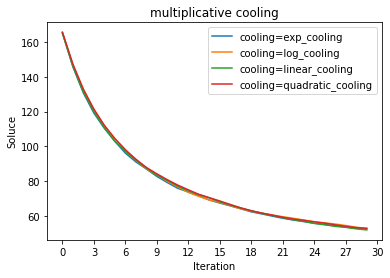

In [210]:
#Choose the best cooling funtion
temperature = 50
alpha = 0.8
nb_levels = 10
nb_rounds = 30
nb_noeuds = 3
f1 = exp_cooling
f2 = log_cooling
f3 = linear_cooling
f4 = quadratic_cooling
functions = [f1,f2,f3,f4]
fig, ax = plt.subplots()  
max_iter = 30
stagnation = 10
x = np.arange(max_iter)
for f in functions:
    records = np.zeros(max_iter)
    for _ in range(nb_rounds):
        SA = Simulated_annealing(coloring.graphe,soluce, alpha ,nb_levels,temperature,max_iter,stagnation,nb_noeuds,f )
        SA.solve()
        records = records + SA.soluce_records
        # print(records)
    records = records / nb_rounds
    ax.plot(x, records, label=f"cooling={f.__name__}")
ax.set_xticks(np.arange(0, max_iter+1, max_iter/10))
ax.set_title("multiplicative cooling")
ax.set_xlabel("Iteration")
ax.set_ylabel("Soluce")
ax.legend() 
plt.show()

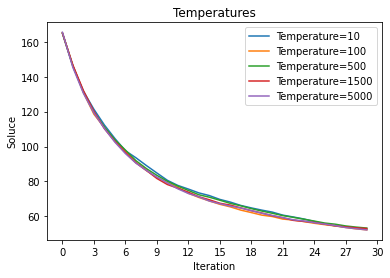

In [212]:
#Choose the best cooling funtion
temperatures = [10,100,500,1500,5000]
f = linear_cooling
alpha = 0.8
nb_levels = 10
nb_rounds = 15
nb_noeuds = 3
f1 = exp_cooling
f2 = log_cooling
f3 = linear_cooling
f4 = quadratic_cooling
functions = [f1,f2,f3,f4]
fig, ax = plt.subplots()  
max_iter = 30
stagnation = 10
x = np.arange(max_iter)
for temperature in temperatures:
    records = np.zeros(max_iter)
    for _ in range(nb_rounds):
        SA = Simulated_annealing(coloring.graphe,soluce, alpha ,nb_levels,temperature,max_iter,stagnation,nb_noeuds,f )
        SA.solve()
        records = records + SA.soluce_records
        # print(records)
    records = records / nb_rounds
    ax.plot(x, records, label=f"Temperature={temperature}")
ax.set_xticks(np.arange(0, max_iter+1, max_iter/10))
ax.set_title("Temperatures")
ax.set_xlabel("Iteration")
ax.set_ylabel("Soluce")
ax.legend() 
plt.show()